<a href="https://colab.research.google.com/github/beatricexc/Predicting-House-Prices-with-ML/blob/main/Predicting_House_Prices_with_ML_Day3ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Logical Steps:**


1.Load Data and Packages

2.Analyzing the Test Variable (Sale Price)

3.Multivariable Analysis

4.Impute Missing Data and Clean Data

5.Feature Transformation/Engineering

6.Modeling and Predictions

**1. Loading the Data Packages**

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb #gradient boosting library, 
                      # It provides parallel boosting trees algorithm that can solve Machine Learning tasks. 
                      #It is available in many languages, like: C++, Java, Python, R, Julia, Scala.
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, LassoLarsCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style= 'white', context = 'notebook', palette = 'deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [87]:
#Load train and Test set 
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [88]:
# Check the number of samples and features
print("The train data size before dropping Id feature is: {} ".format(train.shape))
print("The test dats size before dropping Id feature is : {} ".format(test.shape))

# Save the Id column 
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id column since it's unnecessary for the prediction process. 
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Check the data size after dropping the 'Id' variable 
print("\nThe train data size after dropping Id feature is: {} ".format(train.shape))
print("The test data size after dropping Id feature is: {} ".format(test.shape))

The train data size before dropping Id feature is: (1460, 81) 
The test dats size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is: (1460, 80) 
The test data size after dropping Id feature is: (1459, 79) 


So the training set has 1460 rows and 80 columns whilst the test set has 1459 rows and 79 columns.

In [89]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Looking at the head of both sets, we can see that the only difference in features is "Sale Price". This makes sense because we are trying to predict it!

**2.Analyzing the Test Variable (Sales Price)**

In [90]:
# Getting Description

train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


 mu = 180921.20 and sigma = 79415.29



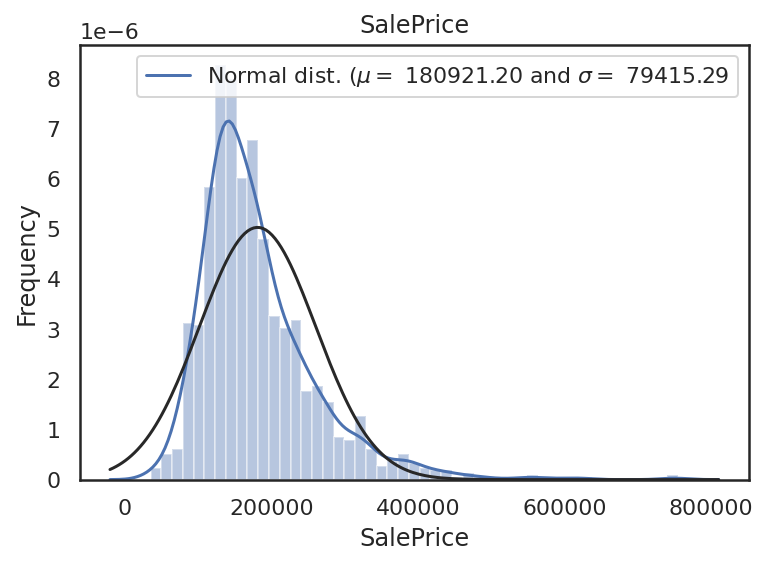

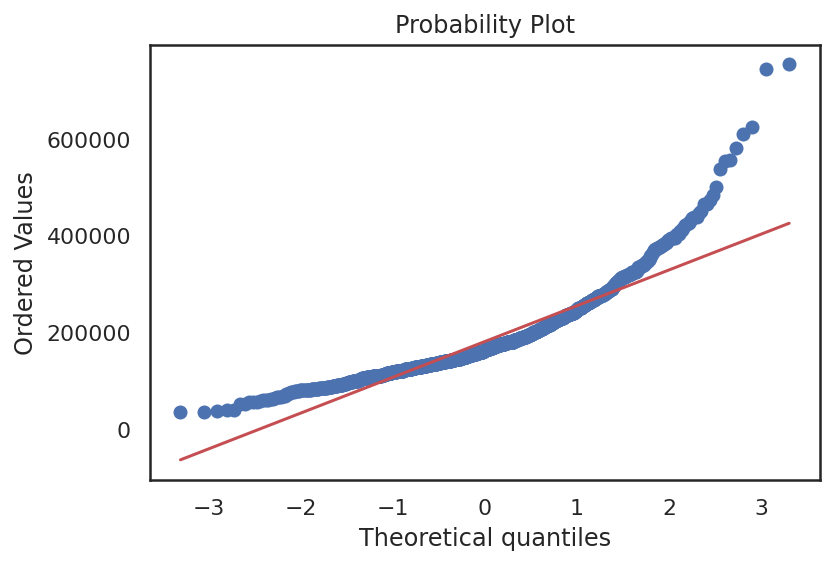

Skewness: 1.882876
Kurtosis: 6.536282


In [91]:
# Plot histogram 
sns.distplot(train['SalePrice'], fit = norm);

# Get the fitted parameters sed by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],
           loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

print("Skewness: %f" % train ['SalePrice'].skew())
print("Kurtosis: %f" % train ['SalePrice'].kurt())


 Looking at the kurtosis score, we can see that there is a very nice peak. However, looking at the skewness score, we can see that the sale prices deviate from the normal distribution. Going to have to fix this later! We want our data to be as "normal" as possible.

**3. Multivariable Analysis**


There are 2 types of features in housing data, categorical and numerical. 


Categorical data follows some kind of pattern but it isn't liner. Numerical data is data in number form. These features are in a linear relationship with each other. Eg: a 2,000 square foot place is 2 x "bigger" than a 1,000 square foot place. Pain and simple 

In [92]:
# Checking categorical data 

train.select_dtypes(include = ['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [93]:
# Checking numerical data 
train.select_dtypes(include = ['int64', 'float64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [94]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64', 'float64']).columns)
print('Total Features: ',cat, 'categorical', '+', 
      num, 'numerical', '=', cat+num, 'features')

Total Features:  43 categorical + 37 numerical = 80 features


Next we're doing the correlation matrix as there are too many fetures to be able to tell which ones are the most related to our house prices.

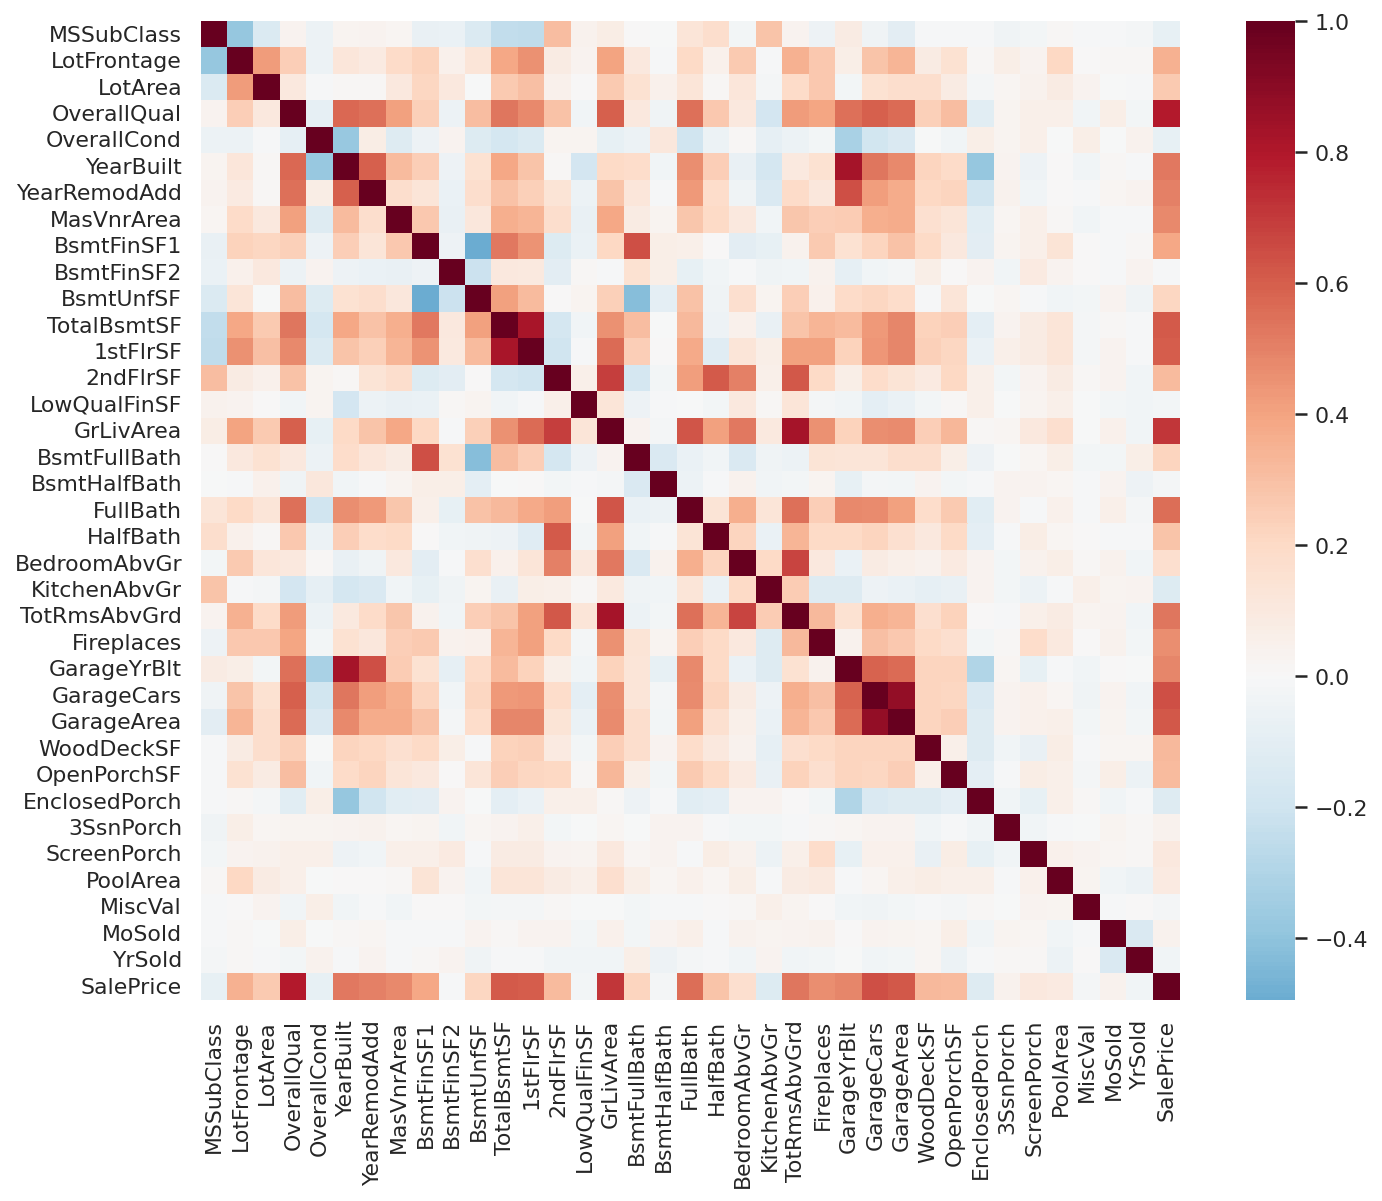

In [95]:
# Correlation Matrix Heatmap

corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap = 'RdBu_r', square=True, center=0);

Too much data so we will zoom into the top 10 most relevant features related to Sales Price. 

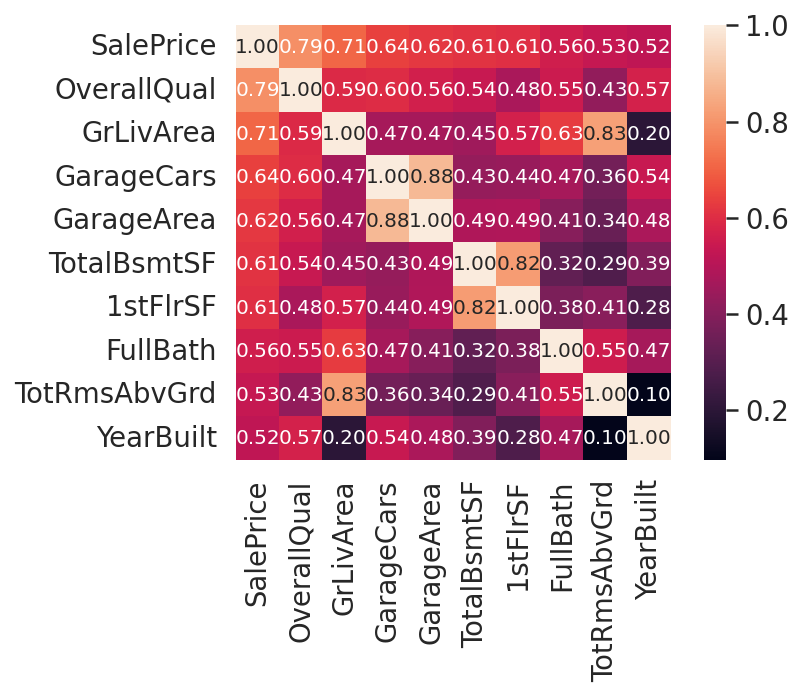

In [96]:
# Top 10 Heatmap

k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [97]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


(-0.5, 9.5, 0.0, 800000.0)

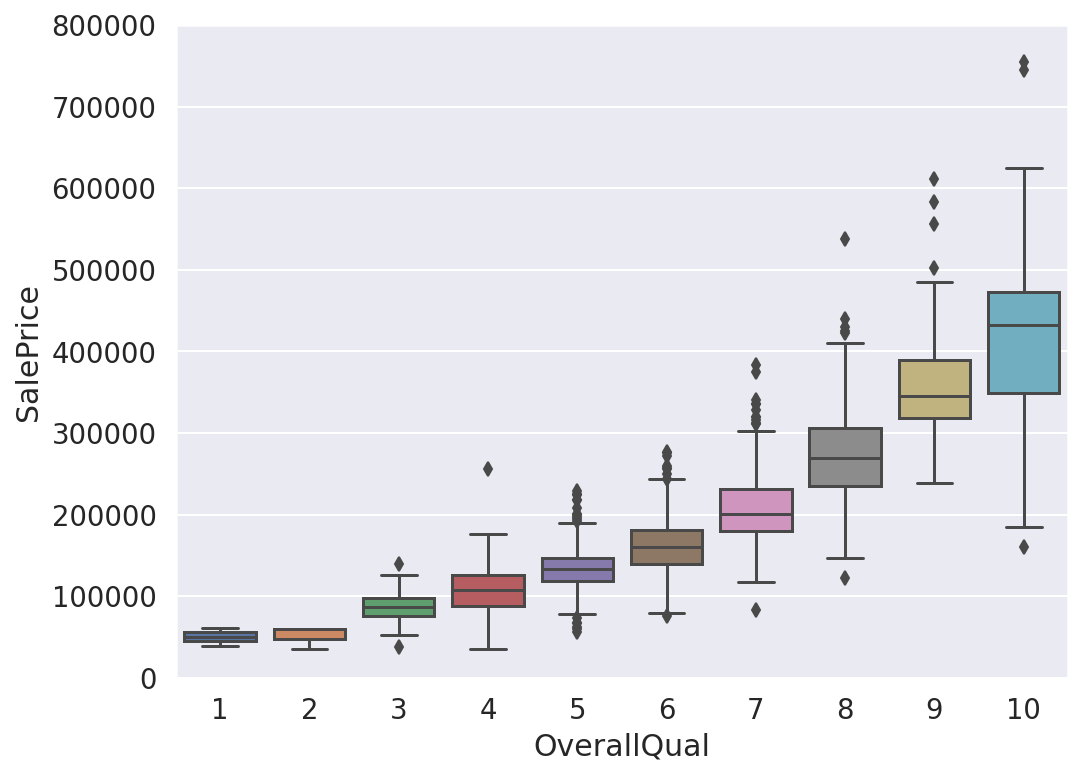

In [98]:
# Taking a loook at how each of the above feautures relate to Sales price + pre-cleaning 

# Overall Quality vs Sale Price 

var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis =1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x = var, y ='SalePrice', data=data)
fig.axis(ymin=0, ymax =800000)

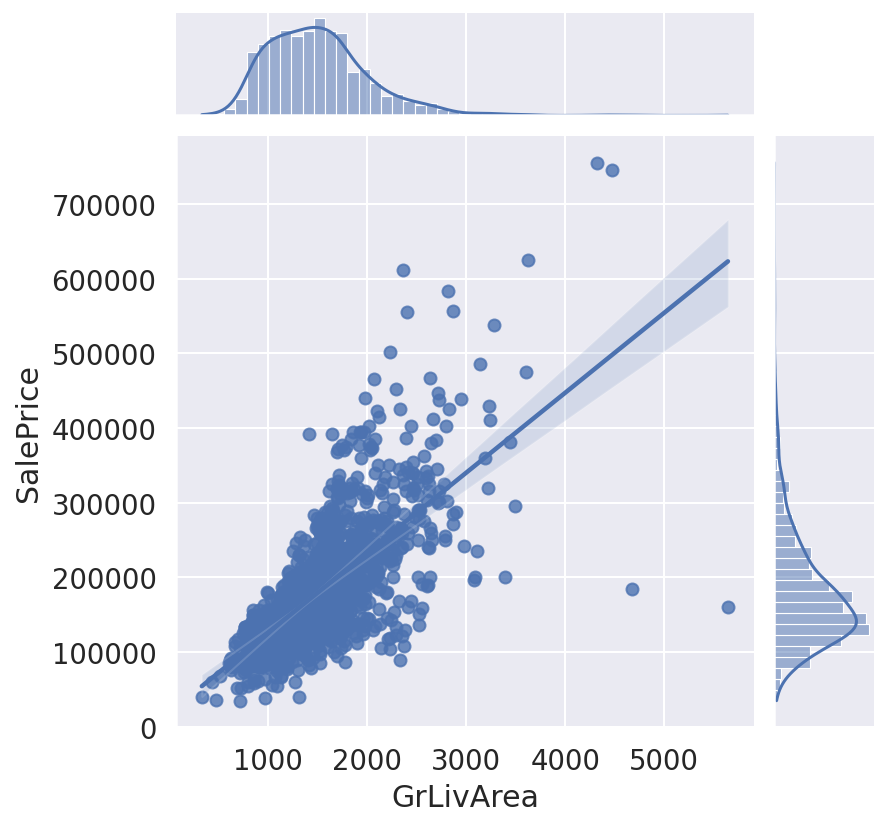

In [99]:
# Living Area vs Sale Price 

sns.jointplot( x=train['GrLivArea'], y = train['SalePrice'], kind = 'reg')


It makes sense that people would pay for the more living area. What doesn't make sense is the two datapoints in the bottom-right of the plot.

We need to take care of this! What we will do is remove these outliers manually.

In [100]:
# Removing outliers manually (the two points in the bottom right)
train = train.drop(train[(train['GrLivArea'] > 4000) 
                           & (train['SalePrice'] < 300000)].index).reset_index(drop = True)

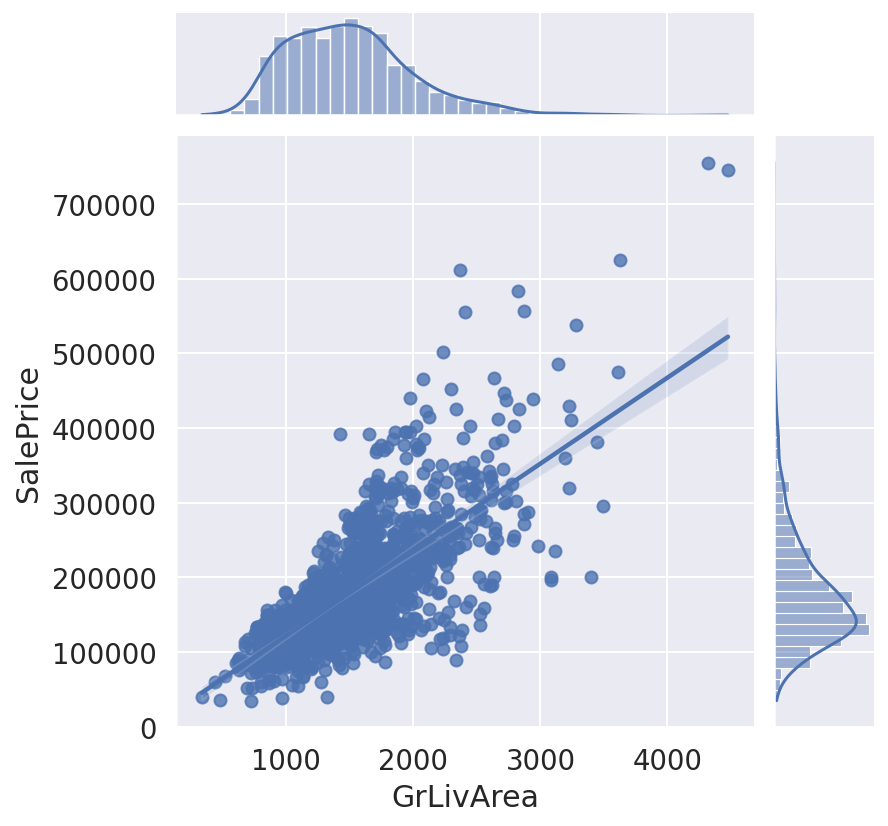

In [101]:
# Living area Vs Sale Price

sns.jointplot( x= train['GrLivArea'], y = train['SalePrice'], kind = 'reg')

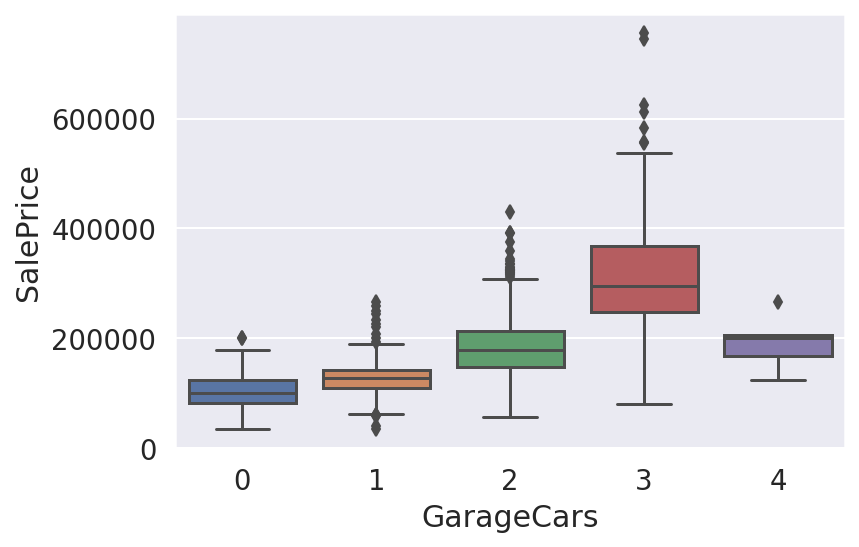

In [102]:
# Garage Area vs Sale Price 
sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])

4-car garages result in less Sale Price? That doesn't make much sense. Let's remove those outliers.

In [103]:
# Removing outliers manually (More than 4-cars, less than $300k)
train = train.drop(train[(train['GarageCars'] >3)
        & (train['SalePrice'] < 300000)].index).reset_index(drop = True )

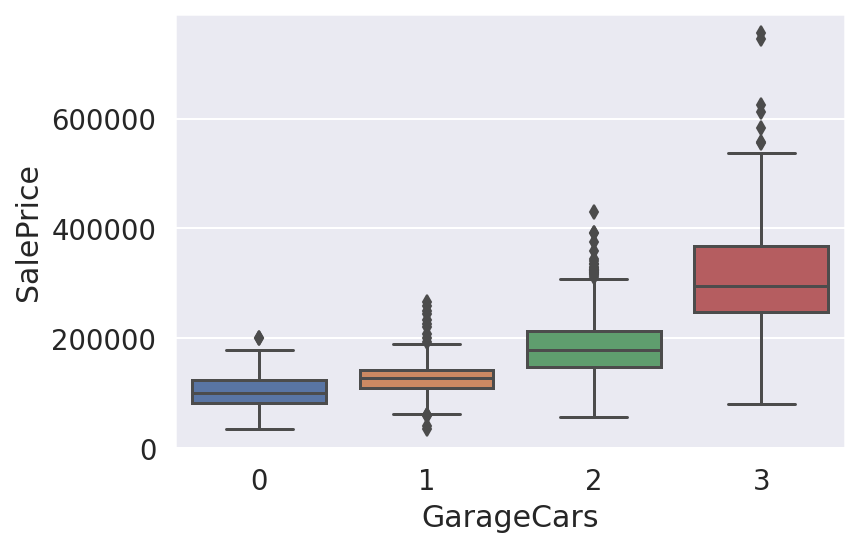

In [104]:
# Garage Area vs Sals Price 
sns.boxplot(x = train['GarageCars'], y = train['SalePrice'])

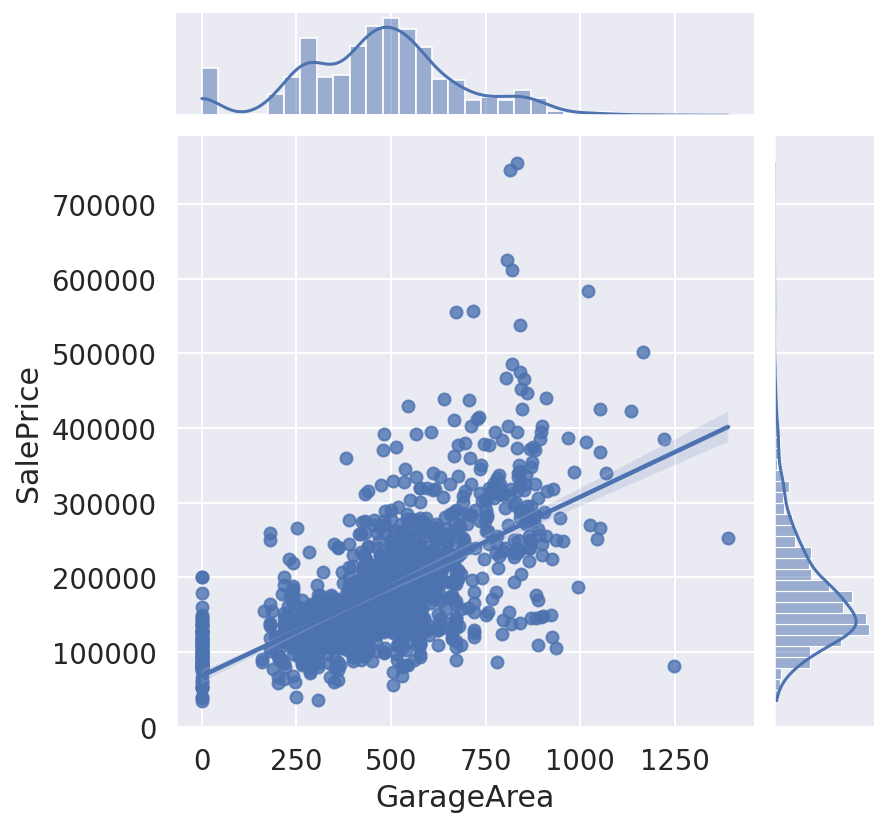

In [105]:
# Garage Area vs Sale Price

sns.jointplot( x= train['GarageArea'], y = train['SalePrice'], kind= 'reg')

Removing the two bottom right outliers manually 

In [106]:
# Removing outliers manually (More than 1000 sqft < $300k)
train = train.drop(train[(train['GarageArea'] > 1000)
        & (train['SalePrice'] < 300000)].index).reset_index(drop = True)

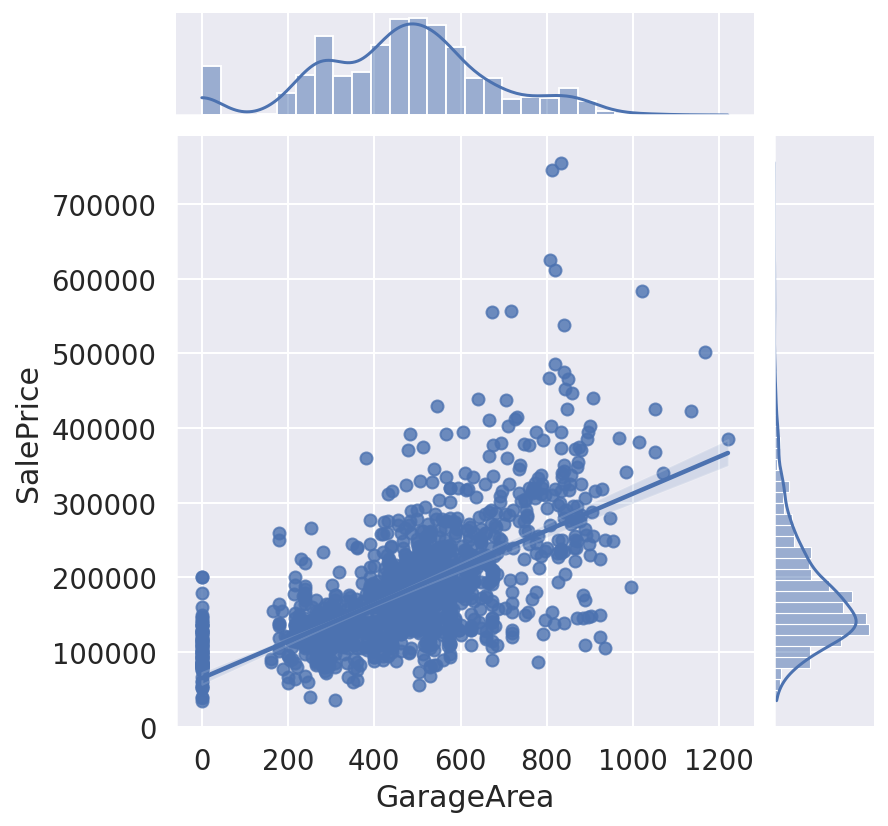

In [111]:
# Garage Area vs Sale Price 
sns.jointplot( x = train['GarageArea'], y = train['SalePrice'], kind = 'reg')

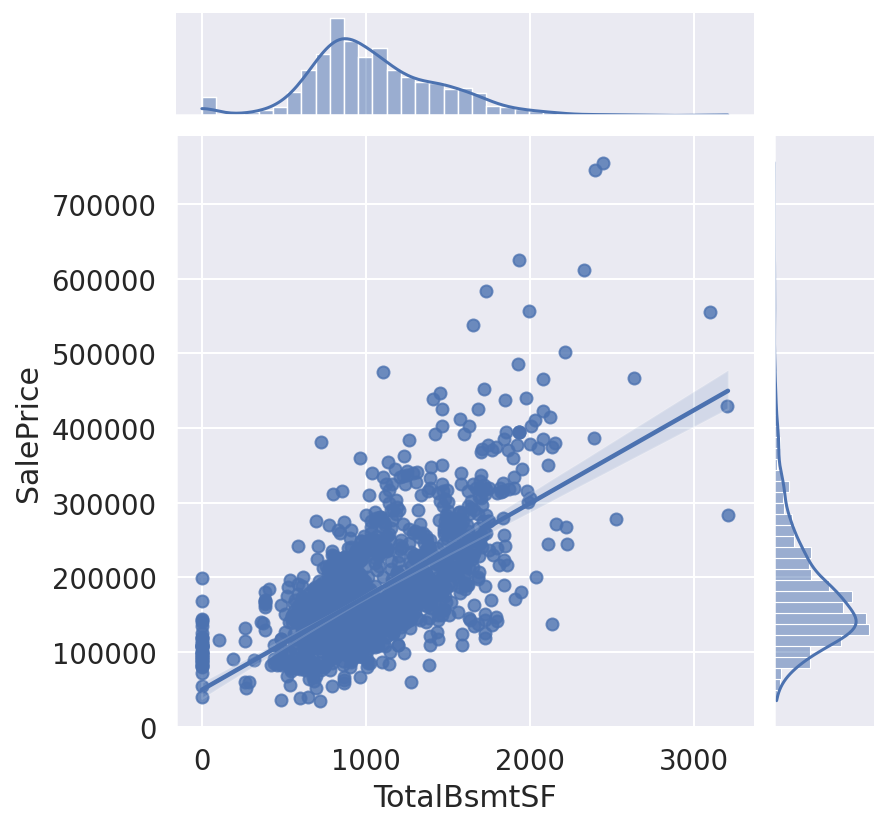

In [110]:
# Basement Area vs Sale Price 
sns.jointplot(x = train['TotalBsmtSF'], y = train['SalePrice'], kind = 'reg')

Everything seems alright here. 

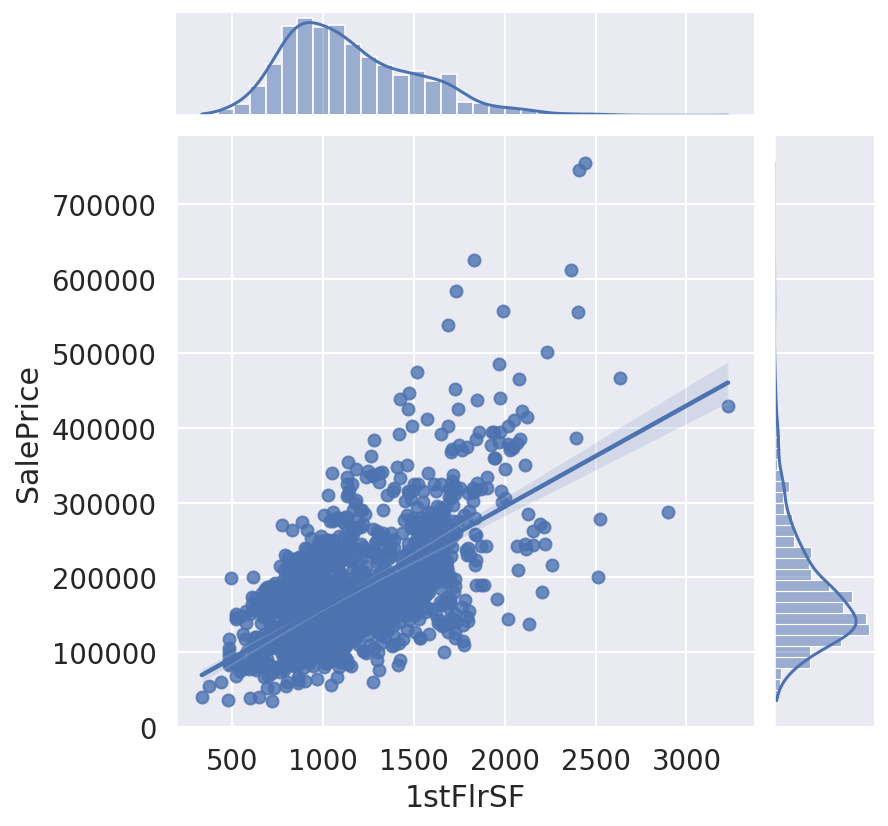

In [109]:
# Frist Floor Area vs Sale Price 
sns.jointplot(x= train['1stFlrSF'], y = train['SalePrice'], kind = 'reg')

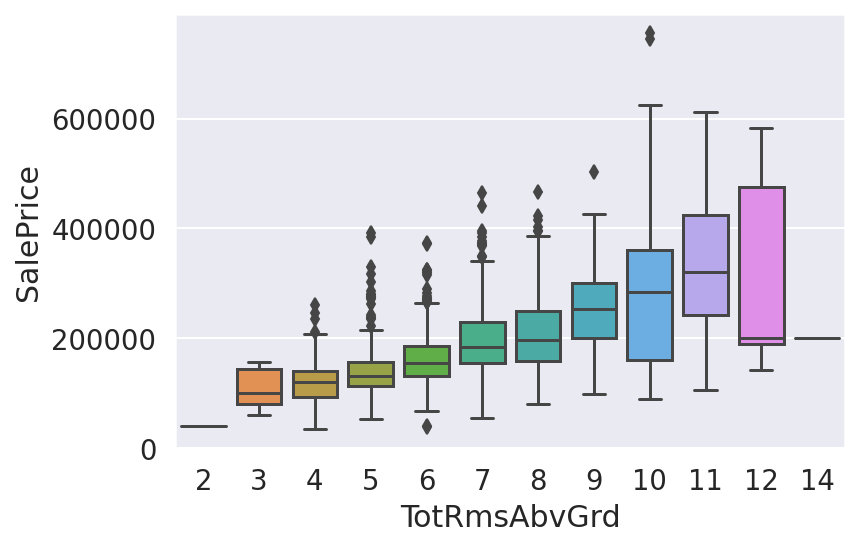

In [ ]:
# Total Rooms vs Sale Price
sns.boxplot(x = train['TotRmsAbvGrd'], y = train['SalePrice'])

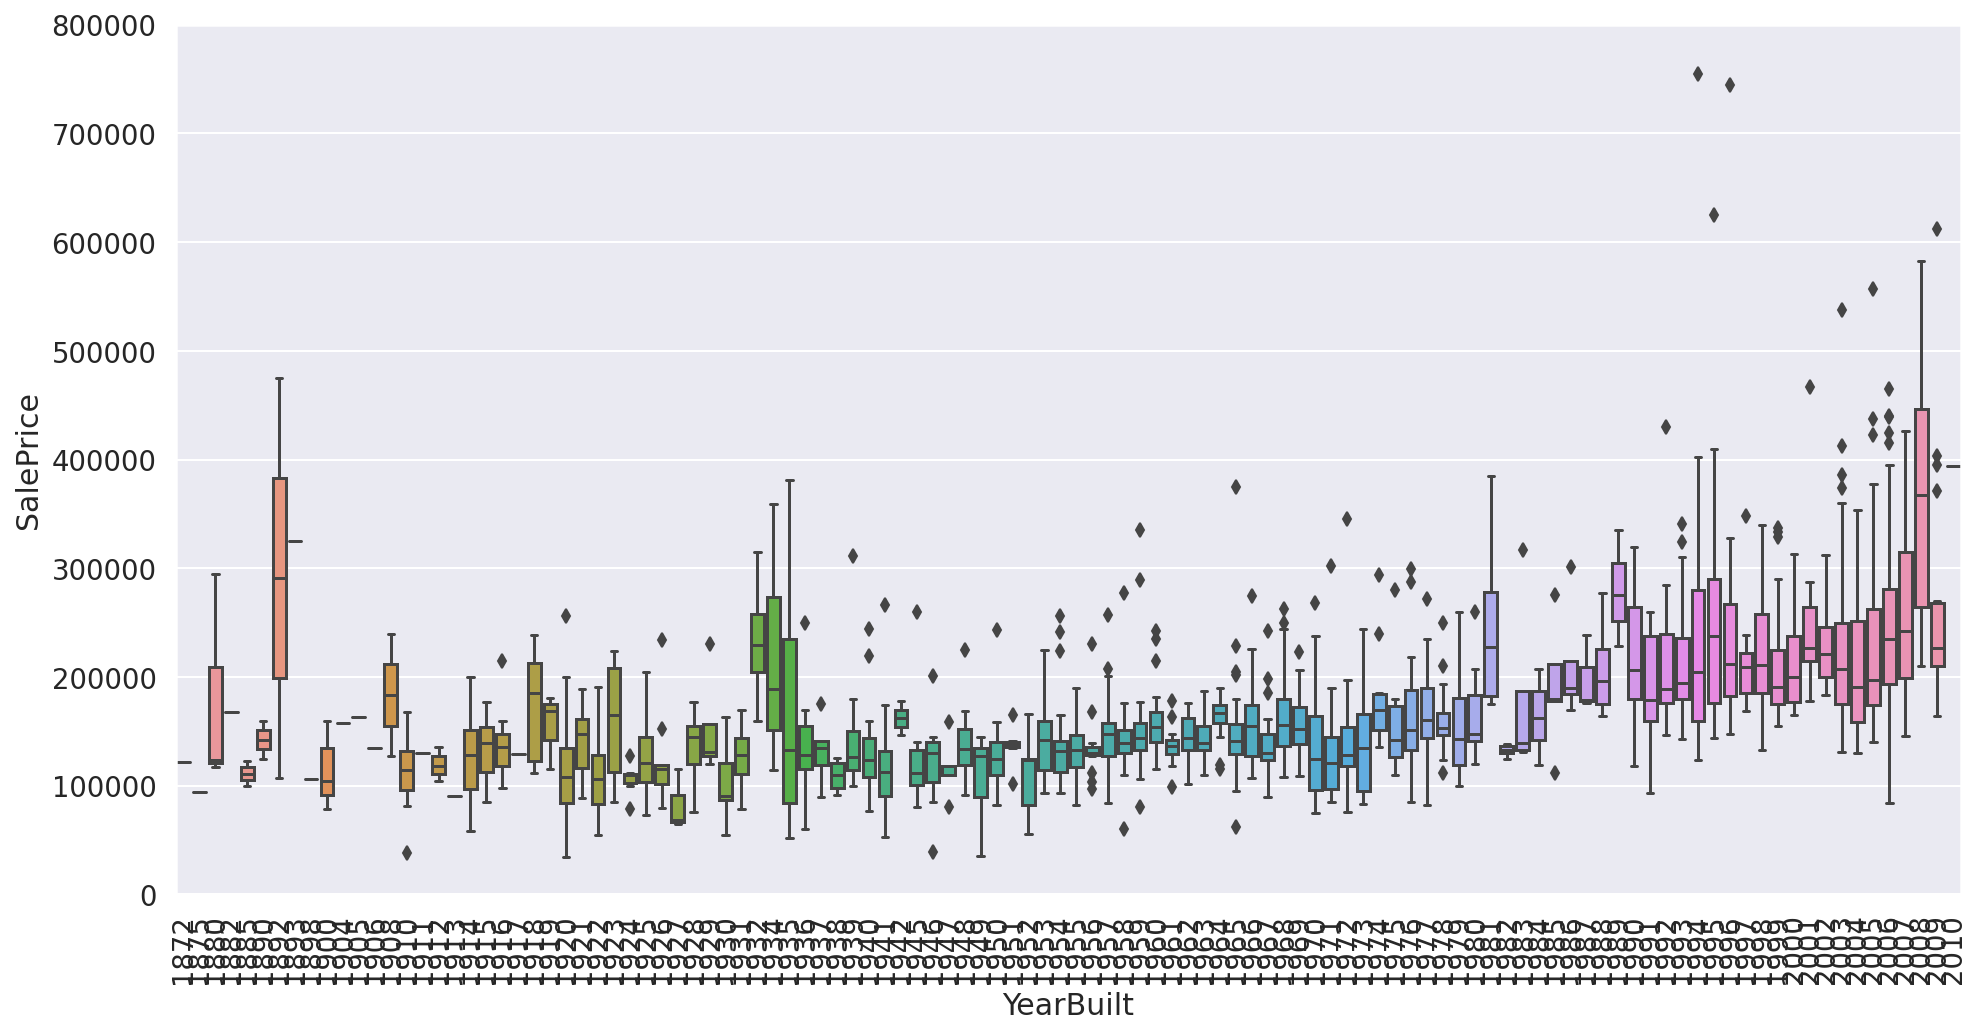

In [ ]:
# Total Rooms vs Sale Price 
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis = 1)
f, ax = plt.subplots(figsize = (16, 8))
fig = sns.boxplot(x = var, y= "SalePrice", data = data)
fig.axis(ymin = 0, ymax =800000);
plt.xticks(rotation=90);

Although it seems like house prices decrease with age, we can't be entirely sure. Is it because of inflation or stock market crashes? Let's leave the years alone.

# 4. Imput Missing Data and Clean Data 

Important questions when thinking about missing data: 

- How prevalent is the missing data?
- Is missing data random or does it have a pattern? 

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, we need to ensure that the missing data process is not biased and hiding an inconvenient truth. 

Let's combine both training and test data into one datsaet tom impute missing values and do some cleaning. 

In [112]:
# Combining Datasets 

ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)
print("Train data size is : {}".format(train.shape))
print("Combined dataset size is: {}".format(all_data.shape))

Train data size is : (1448, 80)
Combined dataset size is: (2907, 79)


In [113]:
# Finding Missing Ratio of Dataset 

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data

,Missing Ratio
PoolQC,99.690402
MiscFeature,96.422429
Alley,93.223254
Fence,80.392157
FireplaceQu,48.710010
LotFrontage,16.683867
GarageFinish,5.469556
GarageYrBlt,5.469556
GarageQual,5.469556
GarageCond,5.469556


Text(0.5, 1.0, 'Percent missing data by feature')

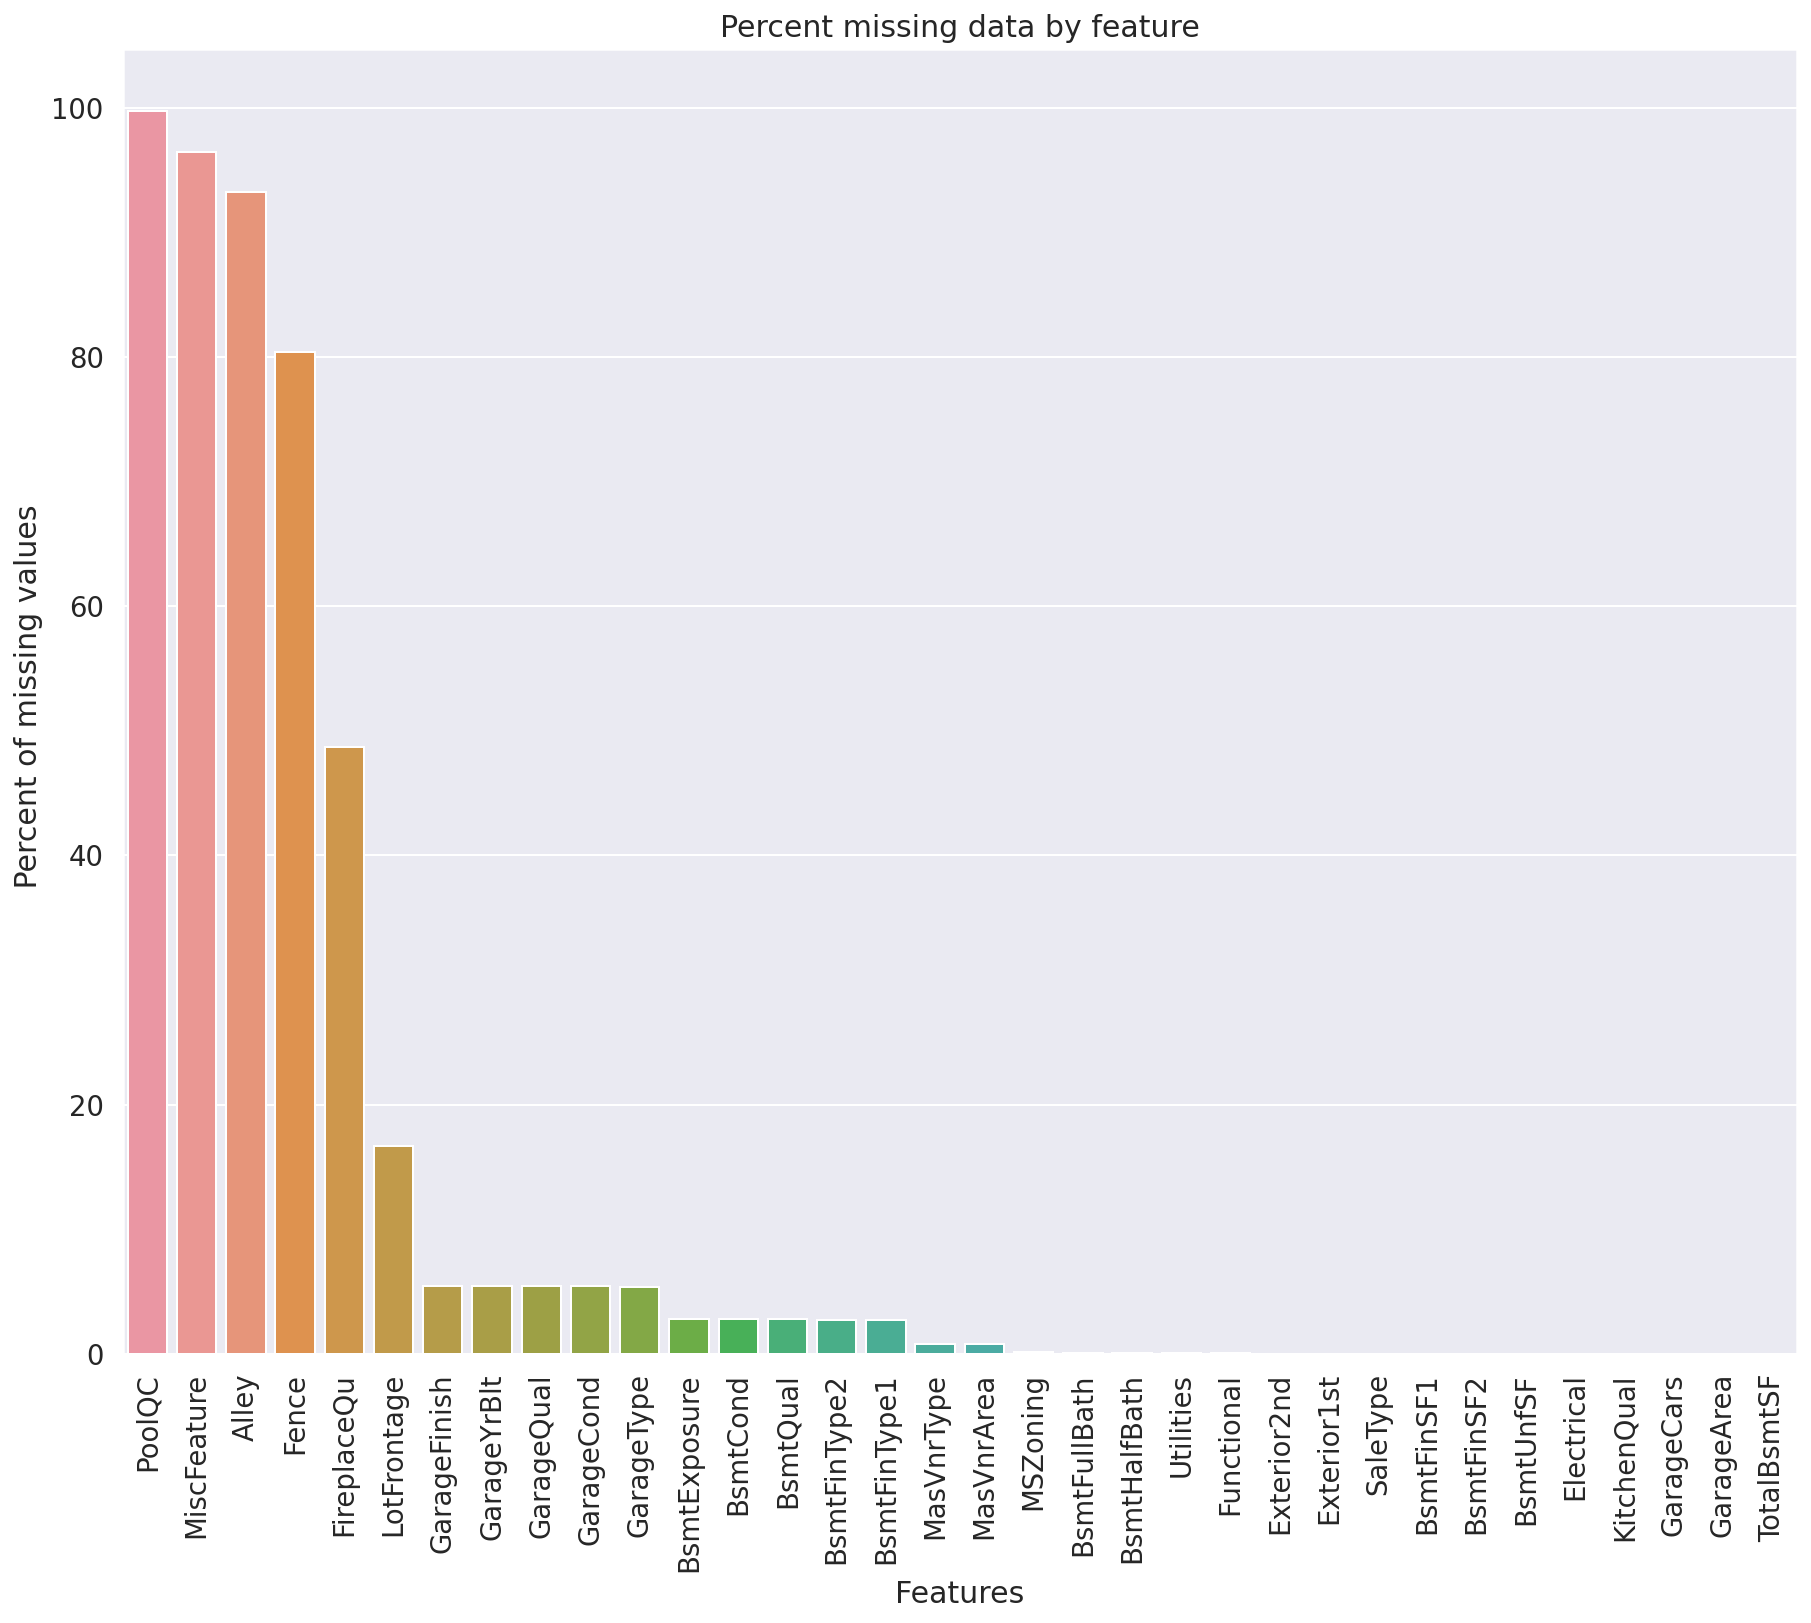

In [114]:
# Percent missing by Feature 
f, ax = plt.subplots(figsize = (15, 12))
plt.xticks(rotation = '90')
sns.barplot(x = all_data_na.index, y= all_data_na)
plt.xlabel('Features', fontsize = 15)
plt.ylabel(' Percent of missing values', fontsize= 15)
plt.title ('Percent missing data by feature',fontsize = 15)

**Imputing Missing Values**



* PoolQC : data description says NA means "No Pool </br>
*MiscFeature : data description says NA means "no misc feature" </br>
*Alley : data description says NA means "no alley access" </br>
*Fence : data description says NA means "no fence" </br>
*FireplaceQu : data description says NA means "no fireplace" </br>
*LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood. </br>
*GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with "None". </br>
*GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0.</br>
*BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath: Replacing missing data with 0.</br>
*BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there isn't a basement. </br>
*MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.</br>
*MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'. </br>
*Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it. </br>
*Functional : data description says NA means typical.</br>
*Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value. </br>
*KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.</br>
*Exterior1st and Exterior2nd : Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string </br>
*SaleType : Fill in again with most frequent which is "WD"</br>
*MSSubClass : Na most likely means No building class. We can replace missing values with None </br>







In [115]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [116]:
# Check if there are any missing values left

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0 ].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head()

,Missing Ratio


# Feature Transformation/ Engineering 

MSSubClass : Identifies the type of dwelling involved in the sale 

* 20 1-STORY 1946 & NEWER ALL STYLES
* 30 1-STORY 1945 & OLDER
* 40 1-STORY W/FINISHED ATTIC ALL AGES
* 45 1-1/2 STORY - UNFINISHED ALL AGES
* 50 1-1/2 STORY FINISHED ALL AGES
* 60 2-STORY 1946 & NEWER
* 70 2-STORY 1945 & OLDER
* 75 2-1/2 STORY ALL AGES
* 80 SPLIT OR MULTI-LEVEL
* 85 SPLIT FOYER
* 90 DUPLEX - ALL STYLES AND AGES
* 120 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
* 150 1-1/2 STORY PUD - ALL AGES
* 160 2-STORY PUD - 1946 & NEWER
* 180 PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
* 190 2 FAMILY CONVERSION - ALL STYLES AND AGES




In [117]:
all_data['MSSubClass'].describe()

count    2907.000000
mean       57.094943
std        42.510238
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

So, the average is a 57 type. What does that mean? Is a 90 type 3 times better than a 30 type? This feature was interpreted as numerical when it is actually categorical. The types listed here are codes, not values. Thus, we need to feature transformation with this and many other features.


In [118]:
# MSSubClas= the building class

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features 
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In our previous example, we could tell that our categories don't follow a particular order. What about categories that do? Let's take a look at "Kitchen Quality".

In [119]:
all_data['KitchenQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

Here, data_description.txt comes to the rescue again!

Kitchen Quality:

* Ex: Excellent
* Gd: Good
* TA: Typical/Average
* Fa: Fair
* Po: Poor


Is a score of "Gd" better than "TA" but worse than "Ex"? I think so, let's encode these labels to give meaning to their specific orders.

In [120]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
#Process columns and apply LabelEnconder to categorical features 

for c in cols: 
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c] = lbl.transform(list(all_data[c].values))

#Check shape
print('Shape all_data : {}'.format(all_data.shape))

Shape all_data : (2907, 78)


1. Let's engineer one feature to combine square footage. this may be useful later on. 

In [121]:
# Adding Total Square Feet feature 

all_data['TotalSF']= all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

Time to fix the skewed features for better predictions 


 mu = 12.02 and sigma = 0.40



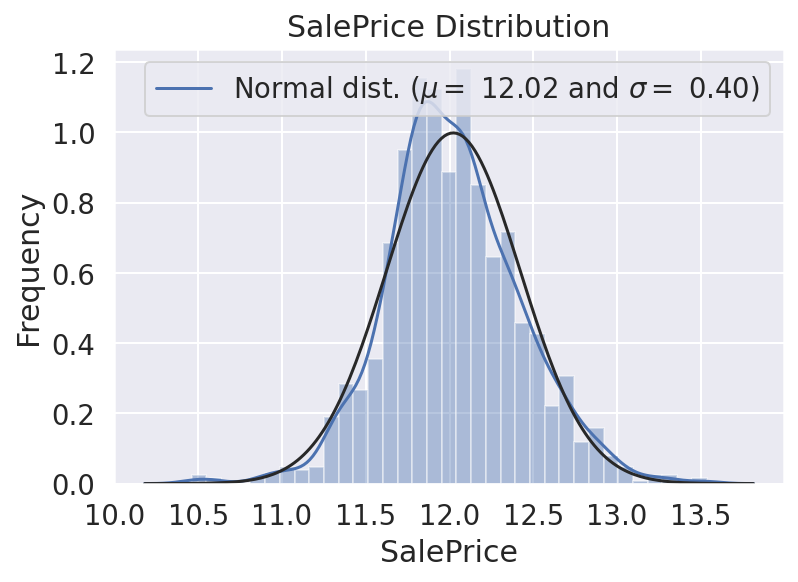

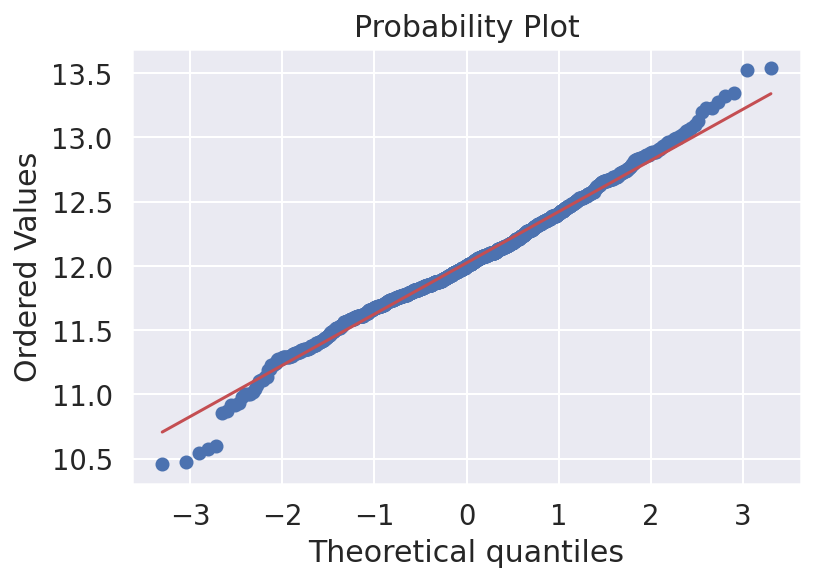

Skewness: 0.130172
Kurtosis: 0.822862


In [122]:
# We use the numpy function log1p which applies log(1+x) to all elements of the column 
train["SalePrice"] = np.log1p(train["SalePrice"])

# Check the new distribution 
sns.distplot(train['SalePrice'], fit = norm);

# Get the fitted parametres used by the function 
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma)) 
plt.legend(['Normal dist. ($\mu = $ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)],
           loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice Distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

y_train = train.SalePrice.values

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [123]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check thes skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame({'Skewed Features': skewed_feats})
skewness.head()

,Skewed Features
MiscVal,21.911765
PoolArea,17.658029
LotArea,13.147728
LowQualFinSF,12.063406
3SsnPorch,11.352135


In [124]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

There are 59 skewed numerical features to Box Cox transform


In [125]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2907, 220)


In [126]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# 6.Modelling and Predictions 

In [127]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split 
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [128]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
  kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(train.values)
  rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring = "neg_mean_squared_error", cv = kf))
  return(rmse)

For this model, we're going to use lasso, elastic net, kernel ridge, gradient boosting , XGBoost, and LightGBM regression

In [129]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

Checking performance of base models by evaluating the cross-validation RMSLE error.

In [130]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std())) 


Lasso score: 0.1111 (0.0071)

ElasticNet score: 0.1111 (0.0072)

Kernel Ridge score: 0.1148 (0.0075)

Gradient Boosting score: 0.1155 (0.0072)

Xgboost score: 0.1187 (0.0055)

LGBM score: 0.1153 (0.0068)



Next we stack the models to average their scores.

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
  def __init__(self, models):
    self.models = models

  # we define clones of the original models to fit the data in
  def fit (self, X, y): 
    self.models_= [clone(x) for x in self.models]

    #Train cloned base models
    for models in self.models_:
      moodel.fit(X, y)

      return self

  # Now we do the predictions for cloned models and average them 
  def predict(self, X):
    predictions = np.column_stack([
                                   model.predict(X) for model in self.models_
    ])
    return np.mean(predictions, axis = 1)
    
                                  

Here we average ENet, GBoost, KRR, and lasso. We'll add in XGBoost and LightGBM later.

In [132]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: nan (nan)

